引力波与暗物质晕交互可视化

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import Planck18  # FlatLambdaCDM, FLRW cosmology with a cosmological constant and no curvature

In [ ]:
# set up other cosmological parameters
z_range = np.linspace(0.1,3,100)
comoving_dist = Planck18.comoving_distance(z_range)

# Distribution of dark matter halo
mass_halo = 1e12 * (1 + z_range)**2.5  # mass-z relation
density_profile = mass_halo / (4/3*np.pi*(100*3.086e21)**3)  # ~100kpc
# visualize
fig, ax = plt.subplots(figsize=(15,10))
im = ax.scatter(comoving_dist, np.zeros_like(z_range), c=density_profile, 
                cmap='viridis', s=mass_halo/1e11, alpha=0.6)
# GW path
wave_path = ax.plot(comoving_dist, 0.1*np.sin(10*comoving_dist.value), 
                    lw=2, color='cyan', label='GW path')

# 相位偏移
for z, d in zip(z_range[::10], comoving_dist[::10]):
    phase_shift = 1e-3 * (1 + z)**2  # 相位偏移模型
    ax.annotate(f'ΔΦ={phase_shift:.1e} rad', (d.value, 0), 
                rotation=45, fontsize=8)
plt.colorbar(im, label='Dark Matter Density (M⊙/pc³)')
ax.set_xlabel('Comoving Distance (Mpc)')
ax.set_title('GW Propagation through Dark Matter Halos')
plt.savefig('GW_lensing.png', dpi=300)

现有算法下双黑洞并合的SNR计算（可用于误报率计算）

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform
from pycbc.noise import gaussian
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.filter import matched_filter
from pycbc.types import TimeSeries
from astropy.cosmology import Planck15 as cosmo

# 设置参数范围
total_mass_range = np.linspace(20, 100, 5)       # 太阳质量
q_range = np.linspace(1, 8, 5)                   # 质量比 q = m1/m2
z_range = np.linspace(0.3, 1.5, 4)               # 红移

# 设置采样率与数据长度
sample_rate = 4096
delta_t = 1.0 / sample_rate
data_len = 8      # 秒数
n_samples = int(data_len * sample_rate)

# 生成 PSD
psd = aLIGOZeroDetHighPower(n_samples//2 + 1, delta_f=1.0/data_len, low_freq_cutoff=20.0)

# 输出结果列表
results = []

for M in total_mass_range:
    for q in q_range:
        m1 = M * q / (1 + q)
        m2 = M / (1 + q)
        for z in z_range:
            # 计算红移距离
            dL = cosmo.luminosity_distance(z).to('Mpc').value

            # 生成波形（仅+极化）
            hp, hc = get_td_waveform(approximant="IMRPhenomPv2",
                                     mass1=m1, mass2=m2,
                                     distance=dL,
                                     inclination=0.0,
                                     delta_t=delta_t,
                                     f_lower=20.0)

            # 将波形裁剪为指定长度，并归一到数据长度
            hp = hp.crop(1, 1)
            hp.resize(n_samples)

            # 生成模拟噪声数据
            noise = gaussian.noise_from_psd(n_samples, delta_t, psd, seed=127)

            # 注入信号
            signal = noise.copy()
            signal.data += hp.data

            # 匹配滤波
            snr = matched_filter(hp, signal, psd=psd,
                                 low_frequency_cutoff=20.0)

            peak_snr = abs(snr).numpy().max()
            results.append((m1, m2, z, peak_snr))

            print(f"m1={m1:.1f}, m2={m2:.1f}, z={z:.2f}, SNR={peak_snr:.2f}") # 误报率的

基于Python的累积相位偏移建模

累积相位偏移（关于z和f）的可视化

In [1]:
from IPython.display import FileLink

 正在处理 z = 0.1
 正在处理 z = 0.5
 正在处理 z = 1.0
 正在处理 z = 1.5
 正在处理 z = 2.0
 正在处理 z = 2.5
 正在处理 z = 3.0
 合成多红移 HMF 保存为：combined_hmf_outputs/combined_hmf_all_z.npz


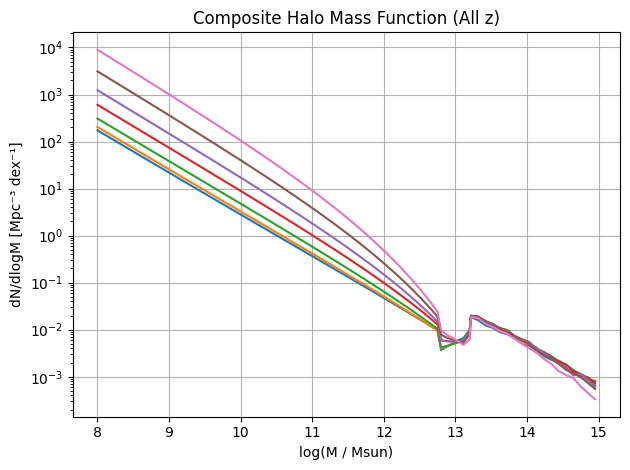

In [11]:
from hmf import MassFunction
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import os

# ----------------- Config -------------------
hmf_model = 'SMT'
join_mass = 1e13  # M_sun/h，拼接质量点
z_list = [0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
snap_to_z = {58: 0.1, 48: 0.5, 40: 1.0, 38: 1.5, 34: 2.0, 32: 2.5, 28: 3.0}
z_to_snap = {v: k for k, v in snap_to_z.items()}
input_npz_path = "halo_mass_function_fixed.npz"
output_dir = "combined_hmf_outputs"
os.makedirs(output_dir, exist_ok=True)

sim_data = np.load(input_npz_path)
mass_bins = sim_data['mass_bins']
mass_centers = 0.5 * (mass_bins[:-1] + mass_bins[1:])
log_mass_sim = np.log10(mass_centers)

npz_output = {'z_list': np.array(z_list)}
final_logM = None

for z in z_list:
    print(f" 正在处理 z = {z}")

    # === 1. ST 低质量段 ===
    mf = MassFunction(z=z, Mmin=8, Mmax=np.log10(join_mass), dlog10m=0.05, hmf_model=hmf_model)
    M_st = mf.m
    logM_st = np.log10(M_st)
    dndlogM_st = mf.dndlog10m  # 已是 Mpc^-3 dex^-1

    # === 2. 模拟数据高质量段 ===
    snap = z_to_snap[z]
    key = f'dn_dlogM_snap{snap}'
    dndlogM_sim = sim_data[key]
    mask_sim = mass_centers >= join_mass
    logM_sim = np.log10(mass_centers[mask_sim])
    dndlogM_sim = dndlogM_sim[mask_sim]

    # === 3. 对 ST 部分进行归一化（匹配拼接点）
    join_logM = np.log10(join_mass)
    st_interp = interp1d(logM_st, dndlogM_st, kind='linear', fill_value='extrapolate')
    sim_interp = interp1d(logM_sim, dndlogM_sim, kind='linear', fill_value='extrapolate')

    scale_factor = sim_interp(join_logM) / st_interp(join_logM)
    dndlogM_st_scaled = dndlogM_st * scale_factor

    # === 4. 平滑拼接区 ±0.2 dex
    overlap_low = join_logM - 0.2
    overlap_high = join_logM + 0.2
    overlap_logM = np.linspace(overlap_low, overlap_high, 10)

    st_scaled_interp = interp1d(logM_st, dndlogM_st_scaled, kind='linear', fill_value='extrapolate')
    sim_interp = interp1d(logM_sim, dndlogM_sim, kind='linear', fill_value='extrapolate')

    overlap_dndlogM = 0.5 * (st_scaled_interp(overlap_logM) + sim_interp(overlap_logM))

    # === 5. 拼接三段
    logM_final = np.concatenate([
        logM_st[logM_st < overlap_low],
        overlap_logM,
        logM_sim[logM_sim > overlap_high]
    ])
    dndlogM_final = np.concatenate([
        dndlogM_st_scaled[logM_st < overlap_low],
        overlap_dndlogM,
        dndlogM_sim[logM_sim > overlap_high]
    ])

    if final_logM is None:
        final_logM = logM_final
        npz_output['logM_bins'] = final_logM
    else:
        interp_final = interp1d(logM_final, dndlogM_final, bounds_error=False, fill_value=0.0)
        dndlogM_final = interp_final(final_logM)

    z_key = f'dN_dlogM_z{str(z).replace(".", "p")}'
    npz_output[z_key] = dndlogM_final

    df = pd.DataFrame({'logM': final_logM, 'dN_dlogM': dndlogM_final})
    df.to_csv(f"{output_dir}/combined_hmf_z{str(z).replace('.', 'p')}.csv", index=False)
    plt.plot(final_logM, dndlogM_final, label=f'z={z}')

np.savez(f"{output_dir}/combined_hmf_all_z.npz", **npz_output)
print(f" 合成多红移 HMF 保存为：{output_dir}/combined_hmf_all_z.npz")

plt.yscale('log')
plt.xlabel('log(M / Msun)')
plt.ylabel('dN/dlogM [Mpc⁻³ dex⁻¹]')
plt.title('Composite Halo Mass Function (All z)')
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/combined_hmf_all_z.png", dpi=300)
plt.show()

波形修正

模板库构建

仿真数据生成

检测匹配滤波